# Practica Modulo Machine Learning -- Daniel Alvaro V4

En este notebook vamos a abordar la práctica del modulo de Machine Learning siguiendo los siguientes pasos.

1. Generación de nuevas características a partir de las existentes
2. Codificación de variables
3. Análisis exploratorio
4. Selección y evaluación del modelo
5. Comparativa de distintos algoritmos

## Version V
En la version V4 se llevan a cabo los siguientes cambios:
- Se incrementa el modelo Lasso polinomico de grado 2 a grado 3

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to calculate missing values by column
def missing_values_table(df):
   
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    
    # Print some summary information
    print("Your slelected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [3]:
# Function to change not main categories to "Other", this funtion will be used in train and test to keep coherence between datasets
def change_cat_to_other(array_main_cat, df):
    array_categories = list(df.value_counts().index)
    array_others = [x for x in array_categories if x not in array_main_cat]
    return df.replace(array_others, 'Other')

## Datos de entrada

Cargamos los datos del fichero de airbnb reducido.
Este fichero contiene 14870 observaciones y 89 variables

In [4]:
full_airbnb = pd.read_csv('./data/airbnb-listings.csv',sep=';', decimal='.')

In [5]:
full_airbnb.shape

(14780, 89)

Antes de nada, vamos a hacer una pequeña limpieza de los outliers de precio, para ver si asi obtenemos unos modelos mas razonables

In [6]:
full_airbnb = full_airbnb[(full_airbnb['Price']>10) & (full_airbnb['Price']<200)]

In [7]:
missing_values_table(full_airbnb)

Your slelected dataframe has 89 columns.
There are 58 columns that have missing values.


,Missing Values,% of Total Values
Has Availability,14049,99.92
Host Acceptance Rate,14027,99.77
Jurisdiction Names,13858,98.56
License,13734,97.68
Square Feet,13487,95.92
Monthly Price,10603,75.41
Weekly Price,10490,74.61
Notes,8676,61.71
Security Deposit,8091,57.55
Interaction,6100,43.39


Antes de llevar a cabo el split entre Trainintg y Test eliminamos las columnas que tenemos claro que no van a ser utiles para nuestro objetivo:
1. **Las que contienen URLs**: Listing Url: drop_url  
2. **Los Ids y lo relativo al Scrape realizado**: drop_id_scrape
3. **Nombres y comentarios**:drop_comments
4. **Direcciones**: A la vista de la informacion que contienen las variables de direccion podemos dropear varias de ellas por diversos motivos (sin que tengamos que dividir previamente en Train Test). Demasiado genericas: City, State, Market, Smart Location, Country Code, Country, Jurisdiction Names. Demasiado concretas: Street, Latitude, Longitude y Geolocation. Demasiado ruido o demasiados registros nulos: Neighbourhood, Host Location, Host Neighbourhood. Por ultimo Zipcode es una variable que para representar la direccion no me parece la mas adecuada debido a que aunque es un numero, deberia ser tratado como una variable categorica. Ademas contiene bastante ruido, una cantidad no despreciable de nulos y tambien es demasiado concreta (506 valores unicos)     Por tanto y para la evaluacion del modelo deberemos barajar cual de las dos opciones que quedan es la mejor para representar la "zona" en la que se encuentra el piso ( Neighbourhood Cleansed o Neighbourhood Group Cleansed, las cuales obviamente van a estar fuertemente correladas), pero esto debera hacerse una vez separado el dataset, para que los datos de Test no influyan en la decision. (En cualquier caso sera necesario hacer un trabajo de limpieza y categorizacion con la variable elegida):drop_address
5. **Informascion relativa al Hospedador**: drop_host

In [8]:
drop_url = np.array(['Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL',
                     'Host Thumbnail Url','Host Picture Url'])
full_airbnb.drop(drop_url, axis=1, inplace=True)

drop_id_scrape = np.array(['ID', 'Scrape ID', 'Last Scraped', 'Host ID', 'Calendar last Scraped'])
full_airbnb.drop(drop_id_scrape, axis=1, inplace=True)


drop_comments = np.array(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                     'Transit','Access', 'Interaction', 'House Rules', 'Host Name', 'Experiences Offered',
                         'Host About', 'Amenities', 'Features'])

full_airbnb.drop(drop_comments, axis=1, inplace=True)

drop_address = np.array(['Host Location', 'Host Neighbourhood', 'Neighbourhood', 'Street', 'Zipcode', 
    'City', 'State', 'Market', 'Smart Location','Country Code', 'Country', 'Latitude', 
                         'Longitude', 'Jurisdiction Names', 'Geolocation'])

full_airbnb.drop(drop_address, axis=1, inplace=True)

drop_host = np.array(['Host Since', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 
    'Host Listings Count', 'Host Total Listings Count','Host Verifications', 'Calculated host listings count'])

full_airbnb.drop(drop_host, axis=1, inplace=True)



Por ultimo eliminamos varios campos sueltos por los siguientes motivos:
* **Square Feet**: Contiene 96% observaciones null
* **Weekly Price**: Contiene 76% observaciones null
* **Monthly Price**: Contiene 76% obsevaciones null
* **Has Availability**: Contiene 99% observaciones null
* **First Review**: No creemos que aporte informacion util para el calculo del precio
* **Last Review**: No creemos que aporte informacion util para el calculo del precio
* **Calendar Updated**: No creemos que aporte informacion util para el calculo del precio
* **License**: Contiene 98% observaciones null
* **Bed Type**: Casi el 99% de las camas son del mismo tipo (Real Bed)




In [9]:
drop_varios = np.array(['Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'First Review', 'Last Review',
                     'Calendar Updated','License', 'Bed Type'])

full_airbnb.drop(drop_varios, axis=1, inplace=True)


In [10]:
full_airbnb.shape

(14060, 29)

In [11]:
missing_values_table(full_airbnb)

Your slelected dataframe has 29 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Security Deposit,8091,57.55
Cleaning Fee,5755,40.93
Review Scores Location,3028,21.54
Review Scores Value,3028,21.54
Review Scores Checkin,3024,21.51
Review Scores Accuracy,3013,21.43
Review Scores Communication,3008,21.39
Review Scores Cleanliness,3007,21.39
Review Scores Rating,2994,21.29
Reviews per Month,2864,20.37


In [12]:
full_airbnb['Price'].describe().T

count    14060.000000
mean        62.066145
std         37.643521
min         11.000000
25%         32.000000
50%         55.000000
75%         80.000000
max        199.000000
Name: Price, dtype: float64

**Tras la limpeza inicial nos hemos quedado con 28 caracteristicas (y el target).**

## Separación Train Test

Ahora, y antes de pasar al analisis exploratorio y la seleccion de caratresiticas procemos a la divsion del dataset de entrada en train y test. De momento y por si llevamos a cabo tratamiento de outliers no separaremos la variable objetivo del resto de caracteristicas.

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_airbnb, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
# Guardamos
train.to_csv('./data/train.csv', sep=';', decimal='.', index=False)
test.to_csv('./data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11248, 29)
Dimensiones del dataset de test: (2812, 29)


**Tengamos en cuenta que a partir de ahora todo el analisis exploratorio y selección de caracteristicas se hara sobre el dataset de entrenamiento.**
**Posteriormente todas transformaciones llevadas a cabo en dicho dataset se deberan implementar en el de Test.**

Empecemos tratando las variables de vecindario (Neighbourhood Cleansed y Neighbourhood Group Cleansed)

In [14]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Cleansed'].unique()))
print(train['Neighbourhood Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Cleansed'].value_counts())

424
0
Embajadores                                                                       1452
Universidad                                                                       1082
Palacio                                                                            825
Sol                                                                                723
Justicia                                                                           611
Cortes                                                                             587
Trafalgar                                                                          234
Palos de Moguer                                                                    207
Argüelles                                                                          200
Goya                                                                               161
Puerta del Angel                                                                   161
Guindalera                           

In [15]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

45
663
Centro                      5280
Chamberí                     710
Arganzuela                   639
Salamanca                    625
Tetuán                       372
Retiro                       352
Moncloa - Aravaca            317
Latina                       294
Chamartín                    288
Carabanchel                  281
Ciudad Lineal                238
Puente de Vallecas           171
Hortaleza                    145
Fuencarral - El Pardo        121
Usera                        118
San Blas - Canillejas        101
Eixample                      88
Barajas                       63
Villaverde                    57
Moratalaz                     56
Villa de Vallecas             32
Sants-Montjuïc                29
Ciutat Vella                  28
Vicálvaro                     26
Gràcia                        25
Brooklyn                      24
Manhattan                     19
Sant Martí                    13
Les Corts                     12
Isole                          9
Fri

A la vista de los datos anteriores tenemos la siguiente informacio:
- La variable "Neighbourhood Cleansed" contiene 449 categorias y ningun valor null.
- La variable "Neighbourhood Group Cleansed contiene 49 categorias y 819 celdas null.En lugar de imputar los nulls a la categoria "Other" lo rellenamos con el valor de la columna "Neighbourhood Cleansed"

In [16]:
train['Neighbourhood Group Cleansed'].fillna(train['Neighbourhood Cleansed'], inplace=True)

A continuación trataremos las otras tres variables categoricas que nos quedan (Property Type, Room Type y Cancellation Policy)

In [17]:
#print(full_airbnb['Neighbourhood'].unique())
print(len(train['Neighbourhood Group Cleansed'].unique()))
print(train['Neighbourhood Group Cleansed'].isna().sum())
with pd.option_context("display.max_rows", 1000):
    print(train['Neighbourhood Group Cleansed'].value_counts())

254
0
Centro                                                                            5280
Chamberí                                                                           710
Arganzuela                                                                         639
Salamanca                                                                          625
Tetuán                                                                             372
Retiro                                                                             352
Moncloa - Aravaca                                                                  317
Latina                                                                             294
Chamartín                                                                          288
Carabanchel                                                                        281
Ciudad Lineal                                                                      238
Puente de Vallecas                   

Es cierto que ahora hemos pasado de 49 categorias a 277, pero creemos que esta distribucion es mas realista que la de incluir tantos pisos en la categoria de Other.

In [18]:
print(train['Property Type'].value_counts())
print(train['Room Type'].value_counts())
print(train['Cancellation Policy'].value_counts())


Apartment             9181
House                  963
Bed & Breakfast        271
Condominium            268
Loft                   246
Other                  176
Dorm                    37
Guesthouse              32
Chalet                  18
Hostel                  12
Townhouse               12
Serviced apartment       9
Villa                    5
Boutique hotel           5
Boat                     4
Casa particular          2
Earth House              2
Bungalow                 1
Guest suite              1
Tent                     1
Camper/RV                1
Timeshare                1
Name: Property Type, dtype: int64
Entire home/apt    6750
Private room       4346
Shared room         152
Name: Room Type, dtype: int64
strict             4282
flexible           3581
moderate           3302
strict_new           23
super_strict_60      18
moderate_new         17
super_strict_30      15
flexible_new         10
Name: Cancellation Policy, dtype: int64


Vamos a dejar las categorias de Property Type en "Apartment", "House", "Condominium", "Bed & Breakfast", "Loft", "Dorm", "Guesthouse", "Chalet", "Townhouse", "Hostel" y "Villa" que representan mas del 95% del total y todas las demas las incluiremos en la categoría "Other".
Para ello usaremos la funcion change_cat_to_other

In [19]:
array_main_cat_property_type = ['Apartment', 'House', 'Condominium', 'Bed & Breakfast', 'Loft', 'Dorm', 'Guesthouse',
                               'Chalet', 'Townhouse', 'Hostel', 'Villa']
train['Property Type'] = change_cat_to_other(array_main_cat_property_type, train['Property Type'])
train['Property Type'].value_counts()

Apartment          9181
House               963
Bed & Breakfast     271
Condominium         268
Loft                246
Other               203
Dorm                 37
Guesthouse           32
Chalet               18
Townhouse            12
Hostel               12
Villa                 5
Name: Property Type, dtype: int64

De la misma manera vamos a dejar las categorias de Cancellation Policy en "strict", "flexible" y "moderate", que representan mas del 96% del total y todas las demas las incluiremos en la categoría "Other".
Usamos nuevamente la funcion change_cat_to_other

In [20]:
array_main_cat_cancellation_policy = ['strict', 'flexible', 'moderate']
train['Cancellation Policy'] = change_cat_to_other(array_main_cat_cancellation_policy, train['Cancellation Policy'])
train['Cancellation Policy'].value_counts()

strict      4282
flexible    3581
moderate    3302
Other         83
Name: Cancellation Policy, dtype: int64

## Codificacion de las variables categoricas (Mean encoding)
Una vez reducidas las categorias de las variables categoricas, las convertiremos en numericas mediante el mecanismo de mean
encoding.
Guardamos las transformacion hechas en Train para reproducirlas en Test con un replace o un map sin volver a aplicar el mean encoding para evitar que los datos de test infulyan en el modelo.
Para aplicar le metodo Mean Encoding es conveniente que no haya NaNs en la variable Target (Price), por ello imputaremos esos valores con la media de los precios.

In [21]:
print(train['Price'].isna().sum())

0


In [22]:
y_train_mean = np.mean(train['Price'])
train['Price'] = train['Price'].fillna(y_train_mean)

In [23]:
print(train['Price'].isna().sum())

0


In [24]:
#Property Type
mean_encode_property_type = train.groupby('Property Type')['Price'].mean()
train.loc[:,'Property Type'] = train['Property Type'].map(mean_encode_property_type)

#Cancellation Policy 
mean_encode_cancellation_policy = train.groupby('Cancellation Policy')['Price'].mean()
train.loc[:,'Cancellation Policy'] = train['Cancellation Policy'].map(mean_encode_cancellation_policy)

#Room Type
mean_encode_room_type = train.groupby('Room Type')['Price'].mean()
train.loc[:,'Room Type'] = train['Room Type'].map(mean_encode_room_type)

#Neighbourhood Cleansed
mean_encode_neigh = train.groupby('Neighbourhood Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Cleansed'] = train['Neighbourhood Cleansed'].map(mean_encode_neigh)

#Neighbourhood Group Cleansed
mean_encode_neigh_group = train.groupby('Neighbourhood Group Cleansed')['Price'].mean()
train.loc[:,'Neighbourhood Group Cleansed'] = train['Neighbourhood Group Cleansed'].map(mean_encode_neigh_group)


Antes de pasar a la correlacion de variables llevemos a cabo un análisis rapido de las caracteristicas que nos quedan

In [25]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Neighbourhood Cleansed,11248.0,62.438122,18.576971,17.500000,51.193237,63.712644,69.968485,198.000000
Neighbourhood Group Cleansed,11248.0,62.438122,16.552478,19.000000,52.400000,67.098295,67.098295,198.000000
Property Type,11248.0,62.438122,4.975710,36.357934,63.379370,63.379370,63.379370,148.000000
Room Type,11248.0,62.438122,23.404771,28.388158,33.967326,81.535852,81.535852,81.535852
Accommodates,11248.0,3.133535,1.835781,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,11207.0,1.227179,0.542385,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,11230.0,1.275067,0.768359,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,11213.0,1.930438,1.381538,1.000000,1.000000,1.000000,2.000000,16.000000
Price,11248.0,62.438122,37.958864,11.000000,32.000000,55.000000,80.000000,199.000000
Security Deposit,4816.0,181.372924,104.837130,0.000000,100.000000,150.000000,200.000000,990.000000


In [26]:
train['Availability 30'].value_counts()
train['Availability 30'].isna().sum()

0

## Correlacion de variables
Tengamos en cuenta que 

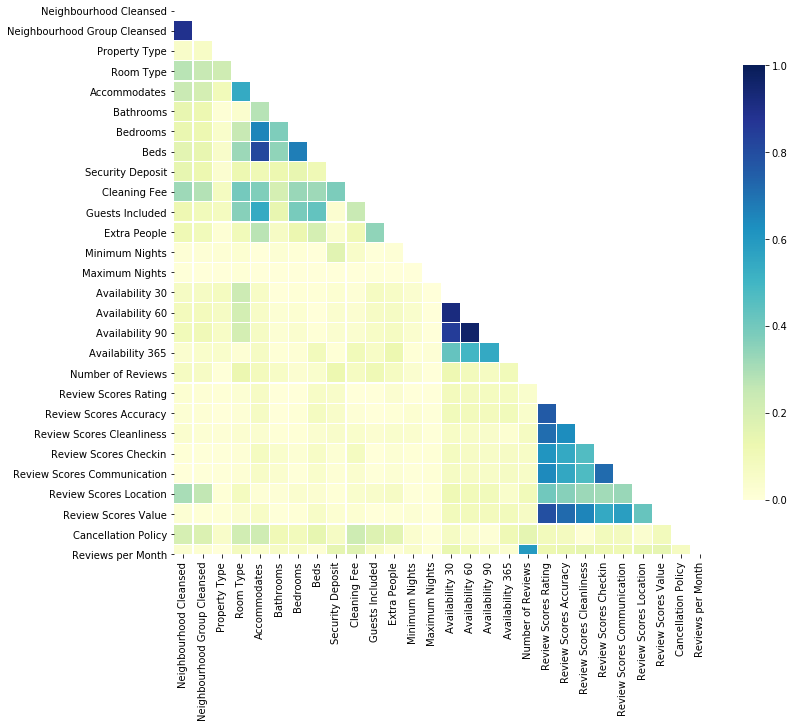

In [27]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Pintemos algunas variables

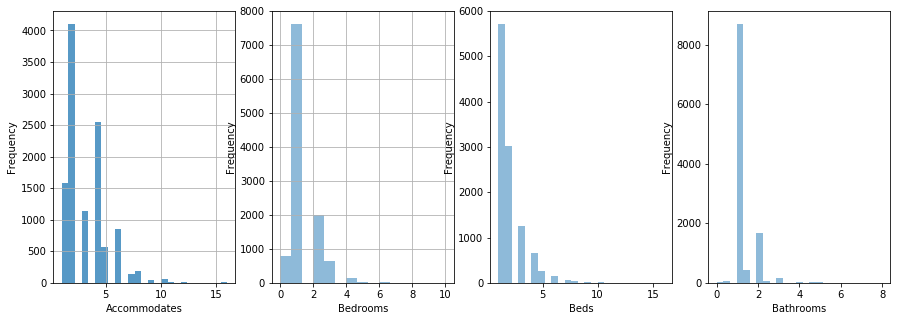

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
train['Accommodates'].plot.hist(alpha=0.75, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('Accommodates')

plt.subplot(1,4,2)
train['Bedrooms'].plot.hist(alpha=0.5, bins=15, grid = True)
plt.xlabel('Bedrooms')

plt.subplot(1,4,3)
train['Beds'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Beds')

plt.subplot(1,4,4)
train['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Bathrooms')

plt.show()

A la vista de la grafica de correlacion y siendo un poco generosos con las variables a eliminar para simplificar el modelo, podemos deducir lo siguiente:
1. **Accommodates** tiene una fuerte correlacion con Bedrooms, Beds y moderada con Guests Included
2. **Availability 30** tiene fuerte correlacion con Availability 60 Availability 90 y moderada con Availability 365
3. **Review Scores Rating** tiene una fuerte correlacion con Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Value y moderada con Review Scores Location.
4. **Number of Reviews** tiene fuerte  correlacion con Reviews per Month
5. **Neighbourhood Cleansed y Neighbourhood Group Cleansed** muestran una fuerte correlacion, pero de momento dejamos las dos para analizar mediante el filtrado de caracterisdtcas cual de las dos influye mas en la regresion que tenemos que plantear.

In [29]:
#Vamos a eliminar todas estas variables del dataset de entrenamiento
drop_corr = ['Bedrooms', 'Beds', 'Guests Included', 'Availability 60', 'Availability 90', 'Availability 365',
             'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication',
             'Review Scores Value', 'Review Scores Location', 'Reviews per Month']
train.drop(drop_corr, axis=1, inplace=True)
train.shape

(11248, 16)

## Separacion variable dependiente 
Separemos el dataset train entre la varible dependiente (y_train) y el resto de variables independientes (X_train)


In [30]:
y_train = train['Price']
X_train= train.drop(['Price'], axis=1)


El siguiente paso es aplicar los metodos de filtrados para regresion, pero esto solo se pueden aplicar sobre variables que no contienen valores NaN.
por tanto analicemos que variables tienen valores NaN y llevemos a cabo el proceso de imputacion, aprovechare para analizar algun posible outlier

Para hacerlo vamos a aplicar los siguientes comandos a todas las variables que quedan:
```
print(len(train['campo'].unique()))
print(train['campo'].isna().sum())
print(train['campo'].value_counts())

```

Haciendo esto vemos que los unicos campos que contienen NaNs son:
- Bathroom (45) Imputamos la media
- Security Deposit (6798). Es mas de la mitad de los regitros por lo que lo eliminamos
- Cleaning Fee (4857). Imputamnos un cero. asumismos que quien no tiene ese dato es porque no hay gastos de limpieza.
- Review Scores Rating (2651). Imputamos la media.

In [31]:
X_train.drop('Security Deposit', axis=1, inplace=True)

In [32]:
mean_bathroom = np.mean(train['Bathrooms'])
mean_review = np.mean(train['Review Scores Rating'])
mean_review

91.64912082957619

In [33]:
X_train['Bathrooms'] = train['Bathrooms'].fillna(mean_bathroom)
X_train['Cleaning Fee'] = train['Cleaning Fee'].fillna(0)
X_train['Review Scores Rating'] = train['Review Scores Rating'].fillna(mean_review)

## Variable objetivo
Por ultimo analizamos la variable objetivo

In [34]:
y_train.describe()

count    11248.000000
mean        62.438122
std         37.958864
min         11.000000
25%         32.000000
50%         55.000000
75%         80.000000
max        199.000000
Name: Price, dtype: float64

In [35]:
print(len(y_train.unique()))
print(y_train.isna().sum())
print(y_train.value_counts())
print(np.mean(y_train)) 

183
0
50.0     516
60.0     455
25.0     442
30.0     440
35.0     372
        ... 
184.0      1
173.0      1
174.0      1
193.0      1
171.0      1
Name: Price, Length: 183, dtype: int64
62.43812233285917


In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11248 entries, 12521 to 2900
Data columns (total 14 columns):
Neighbourhood Cleansed          11248 non-null float64
Neighbourhood Group Cleansed    11248 non-null float64
Property Type                   11248 non-null float64
Room Type                       11248 non-null float64
Accommodates                    11248 non-null int64
Bathrooms                       11248 non-null float64
Cleaning Fee                    11248 non-null float64
Extra People                    11248 non-null int64
Minimum Nights                  11248 non-null int64
Maximum Nights                  11248 non-null int64
Availability 30                 11248 non-null int64
Number of Reviews               11248 non-null int64
Review Scores Rating            11248 non-null float64
Cancellation Policy             11248 non-null float64
dtypes: float64(8), int64(6)
memory usage: 1.3 MB


## Filtrado para regresion
Con las 13 variables que me quedan aplico los metodos de fitrado **f_regresion** y **mutual_info_regresion**

In [37]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

Mostremos esta informacion en forma de grafica

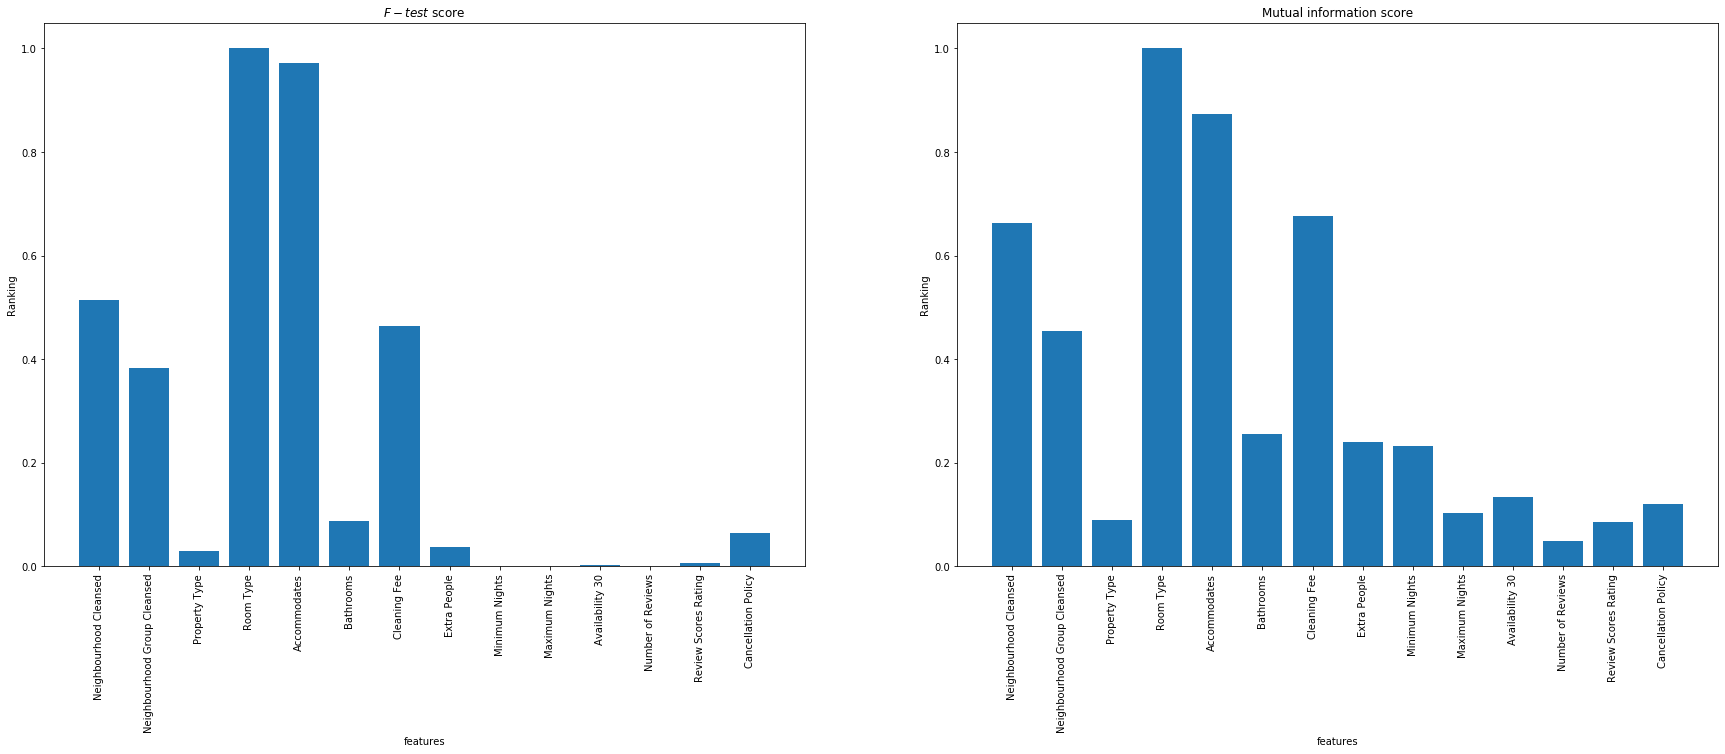

In [38]:
featureNames = list(X_train.columns)

plt.figure(figsize=(30, 10))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

A la vista de las graficas y de los valores de f_test y mi las variables que mas estan impactando en la variable objetivo son:
- Neighbourhood Cleansed (quitamos la grupal pues como ya habiamos visto esta fuertemente correlada con esta)
- Room Type
- Accommodates
- Bathrooms
- Cleaning Fee
- Extra People
- Minimum Nigths
- Availability 30
- cancelation Policy

Como era de esperar el barrio, el tipo de habitacion y las personas que pueden ocupar la casa son los parametros que mas afectan al precio de la casa.

**Me gustaria apuntar aqui que inicialmente habia hecho una prueba haciendo limpieza de la varibale "Neighbourhood Cleansed" poniendo en la categoria 'Others' todos aquellos barrios por debajo de una frecuencia determinada y la influencia de esa variable era mucho menor**

Por tanto seran estas las variables que usare para testear mis modelos, elimando el resto del dataset de training

In [39]:
drop_filtrado = ['Neighbourhood Group Cleansed', 'Property Type','Maximum Nights', 'Number of Reviews', 'Review Scores Rating']
X_train.drop(drop_filtrado, axis=1, inplace=True)

Por ultimo cambiare el nombre de la variable "Neighbourhood Group Cleansed" por "Barrio" para que sea mas manejable

In [40]:
X_train.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)

In [41]:
X_train.describe()

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee,Extra People,Minimum Nights,Availability 30,Cancellation Policy
count,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000,11248.000000
mean,62.438122,62.438122,3.133535,1.227179,16.938389,7.451191,2.934655,8.663940,62.438122
std,18.576971,23.404771,1.835781,0.541396,20.916891,10.309055,12.369022,9.092941,7.343593
min,17.500000,28.388158,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,53.291818
25%,51.193237,33.967326,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.291818
50%,63.712644,81.535852,2.000000,1.000000,10.000000,0.000000,2.000000,6.000000,61.493943
75%,69.968485,81.535852,4.000000,1.000000,30.000000,15.000000,3.000000,13.000000,70.453293
max,198.000000,81.535852,16.000000,8.000000,250.000000,276.000000,1125.000000,30.000000,81.108434


## Normalizacion
Por ultimo llevamos a cabo el escalado mediante StandarEscales
Recordemos que para test deberemos usar el scaler obtenido en train


In [42]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

**Y hasta aqui el analisis exploratorio y la limpieza del dataset, empezamos con las pruebas de los modelos**

## Prueba de Modelos

Antes de iniciar la evaluacion de modelos, vamos a dejar preparado el **dataset de Test** con las mismas transformaciones que hemos llevado a cao sobre el de Train.
Abajo indicamos el listado de dichas transformaciones para no olvidarnos de ninguna:
- Lo primero es el dropeo de las variables que no van a participar en el modelo (correlacion y filtrado): drop_corr y drop_filtrado.
- Tratamiento de las variables categoricas que influyen en el modelo (filtrado de categorias y Encoder): encoder_room_type y encoder_neigh_group
- Tratamiento de NaNs: Bathroom y Cleaning Fee


Analizamos y limpiamos el dataset de test

In [43]:
test = pd.read_csv('./data/test.csv',sep=';', decimal='.')
test.shape
#test.info()

(2812, 29)

In [44]:
missing_values_table(test)

Your slelected dataframe has 29 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Security Deposit,1659,59.00
Cleaning Fee,1169,41.57
Review Scores Location,629,22.37
Review Scores Value,629,22.37
Review Scores Checkin,628,22.33
Review Scores Accuracy,625,22.23
Review Scores Cleanliness,624,22.19
Review Scores Communication,623,22.16
Review Scores Rating,618,21.98
Reviews per Month,589,20.95


A la vista de los datos de arriba vemos que Price tienen valores NaN(3), por ello deberemos limpiarlos 

In [45]:
#Dropeamos
test.drop(drop_corr, axis=1, inplace=True)
test.drop(drop_filtrado, axis=1, inplace=True)

#Eliminamos tambien la variable Security Deposit 
test.drop('Security Deposit', axis=1, inplace=True)

#imputamos los valores NaNs del target con la media del train (y_train_mean)
media_target_test = np.mean(test['Price'])
test['Price'] = test['Price'].fillna(y_train_mean)

#Imputamos los NaNs de la misma manera que se hace en Train
test['Bathrooms'] = test['Bathrooms'].fillna(mean_bathroom)
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(0)


#Aplicamos el Mean Encoder a "Room Type", "Neighbourhood Cleansed" y "Cancellation Policy"  el obtenido en train, si aparece alguna categoria nueva en test
#lo trataremos a posteriori
#mean_encode_room_type_test = test.groupby('Room Type')['Price'].mean()
#mean_encode_neigh_test = test.groupby('Neighbourhood Cleansed')['Price'].mean()
#mean_encode_cancellation_policy_test = test.groupby('Cancellation Policy')['Price'].mean()
test.loc[:,'Room Type'] = test['Room Type'].map(mean_encode_room_type)
test.loc[:,'Neighbourhood Cleansed'] = test['Neighbourhood Cleansed'].map(mean_encode_neigh)
test.loc[:,'Cancellation Policy'] = test['Cancellation Policy'].map(mean_encode_cancellation_policy)


#Por ultimo cambiamos el nombre de la variable a Barrio
test.rename(columns={'Neighbourhood Cleansed':'Barrio'}, inplace=True)


In [46]:
missing_values_table(test)

Your slelected dataframe has 10 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Barrio,26,0.92
Cancellation Policy,22,0.78


Como quedan valores nulos en Barrio y Cancellation Policy debido a aplicar sobre ellas el Mean Encoding de train, lo rellenaremos con la media de las medias obtenidas para esas categoria

In [47]:
mean_mean_encode_neigh = np.mean(mean_encode_neigh)
mean_mean_encode_cancellation_policy = np.mean(mean_encode_cancellation_policy)
mean_mean_encode_cancellation_policy

66.58687189537717

In [48]:
test['Barrio'].fillna(mean_mean_encode_neigh, inplace=True)
test['Cancellation Policy'].fillna(mean_mean_encode_cancellation_policy, inplace=True)

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812 entries, 0 to 2811
Data columns (total 10 columns):
Barrio                 2812 non-null float64
Room Type              2812 non-null float64
Accommodates           2812 non-null int64
Bathrooms              2812 non-null float64
Price                  2812 non-null float64
Cleaning Fee           2812 non-null float64
Extra People           2812 non-null int64
Minimum Nights         2812 non-null int64
Availability 30        2812 non-null int64
Cancellation Policy    2812 non-null float64
dtypes: float64(6), int64(4)
memory usage: 219.8 KB


Separamos la variable objetivo del tets

In [50]:
y_test = test['Price']
X_test= test.drop(['Price'], axis=1)

In [51]:
X_test

,Barrio,Room Type,Accommodates,Bathrooms,Cleaning Fee,Extra People,Minimum Nights,Availability 30,Cancellation Policy
0,56.500000,81.535852,3,1.0,19.0,0,1,17,61.493943
1,65.233826,81.535852,4,1.0,50.0,0,5,4,70.453293
2,68.653846,81.535852,4,1.0,30.0,0,1,0,70.453293
3,34.795031,33.967326,2,1.0,0.0,0,1,19,70.453293
4,52.830189,81.535852,7,1.0,30.0,17,1,21,70.453293
...,...,...,...,...,...,...,...,...,...
2807,68.176759,33.967326,2,1.0,0.0,10,1,0,70.453293
2808,68.176759,81.535852,2,1.0,10.0,0,1,0,53.291818
2809,65.233826,81.535852,2,1.0,30.0,0,5,5,70.453293
2810,60.264706,33.967326,2,1.0,0.0,0,2,12,70.453293


Normalizamos los datos de Test

In [52]:
XtestScaled = scaler.transform(X_test)

## Ridge Model
Por convenio se recomienda empezar con una regresion regularizada tipo Ridge

Valores de alpha: [  0.1          0.14384499   0.20691381   0.29763514   0.42813324
   0.61584821   0.88586679   1.27427499   1.83298071   2.6366509
   3.79269019   5.45559478   7.8475997   11.28837892  16.23776739
  23.35721469  33.59818286  48.32930239  69.51927962 100.        ]
best mean cross-validation score: -555.701
best parameters: {'alpha': 48.32930238571752}


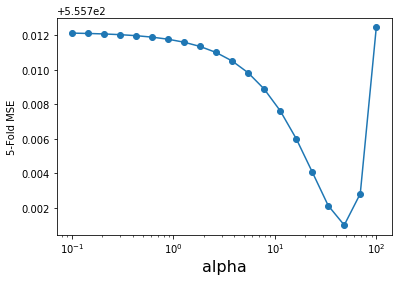

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge


alpha_vector = np.logspace(-1,2,20)
param_grid = {'alpha': alpha_vector }
print(f'Valores de alpha: {alpha_vector}')
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
#plt.ylim((0, 1))
plt.show()

Entrenamos el modelo ahora con el valor óptimo de $\alpha$ que hemos encontrado con validación cruzada.

In [54]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainRidge = ridge.predict(XtrainScaled)
ytestRidge  = ridge.predict(XtestScaled)
mseTrainModelRidge = mean_squared_error(y_train,ytrainRidge)
mseTestModelRidge = mean_squared_error(y_test,ytestRidge)

print('MSE Modelo Ridge (train): %0.3g' % mseTrainModelRidge)
print('MSE Modelo Ridge (test) : %0.3g' % mseTestModelRidge)

print('RMSE Modelo Ridge (train): %0.3g' % np.sqrt(mseTrainModelRidge))
print('RMSE Modelo Ridge (test) : %0.3g' % np.sqrt(mseTestModelRidge))

feature_names = X_test.columns[0:]
w = ridge.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Ridge (train): 554
MSE Modelo Ridge (test) : 556
RMSE Modelo Ridge (train): 23.5
RMSE Modelo Ridge (test) : 23.6
Barrio 10.903286961971306
Room Type 13.250872082003186
Accommodates 11.055682223585059
Bathrooms 3.977621036694197
Cleaning Fee 6.092639423853135
Extra People -1.3085771933237538
Minimum Nights -0.3425454213022323
Availability 30 3.4644806465346702
Cancellation Policy -2.000382694495949


## Lasso Model

best mean cross-validation score: -555.568
best parameters: {'alpha': 0.01}


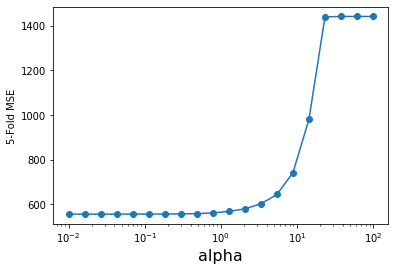

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-2,2,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = X_train.columns[0:]
w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 554
MSE Modelo Lasso (test) : 556
RMSE Modelo Lasso (train): 23.5
RMSE Modelo Lasso (test) : 23.6
Barrio 10.930623129139224
Room Type 13.293014097048271
Accommodates 11.071273295560584
Bathrooms 3.9806087058203876
Cleaning Fee 6.083438489003092
Extra People -1.3128756422679293
Minimum Nights -0.33399955659916536
Availability 30 3.480979755173646
Cancellation Policy -2.013242077684464


**Como vemos, tanto los valores de Ridge como los de Lasso son muy parecidos **

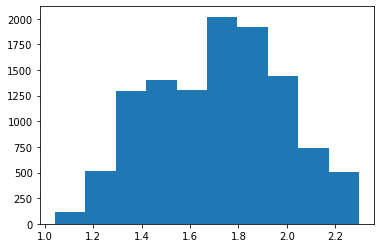

In [57]:
plt.hist(np.log10(y_train), bins=10)
plt.show()

A la vista de esta distribucion no parece que pueda tener mucho sentido aplicar una transformacion logaritmica

Antes de pasar a probar con un random Forest voy a hacer una ultima prueba con Lasso y una regresion polinomica de grado 2. A fin de cuentas, se ha visto en el filtrado de caracteristicas que hay bastante dependencia no lineal de ciertas caracteristicas por lo que el modelo podria funcionar mejor.


In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 

degree = 3

# features
poly    = PolynomialFeatures(degree) # generamos x^j
X_train_poly = poly.fit_transform(X_train.values.reshape(-1, 9))

X_test_poly = poly.fit_transform(X_test.values.reshape(-1, 9))


In [59]:
len(X_train_poly[0])

220

**Normalizamos**

In [60]:
scaler_poly = preprocessing.StandardScaler().fit(X_train_poly)
XtrainScaled_poly = scaler_poly.transform(X_train_poly)
XtestScaled_poly = scaler_poly.transform(X_test_poly)

In [61]:
XtrainScaled.shape

(11248, 9)

**Parametros optimos mediante GridSearchCV**

C:\Users\Texelia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best mean cross-validation score: -474.584
best parameters: {'alpha': 0.05736152510448681}


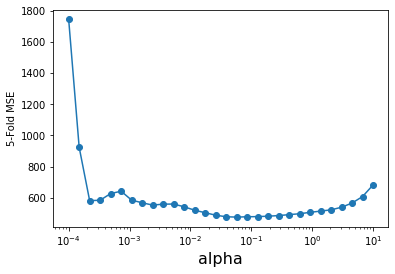

In [62]:
alpha_vector = np.logspace(-4,1,30)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled_poly, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [63]:
grid.best_params_['alpha']

0.05736152510448681

**Por ultimo y usando el alpha optimo obtenido en el apartado anterior, entrenamos el modelo**

In [64]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled_poly,y_train)

ytrainLasso = lasso.predict(XtrainScaled_poly)
ytestLasso  = lasso.predict(XtestScaled_poly)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = X_train.columns[1:]
w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 449
MSE Modelo Lasso (test) : 455
RMSE Modelo Lasso (train): 21.2
RMSE Modelo Lasso (test) : 21.3
Room Type 0.0
Accommodates 8.321879629523425
Bathrooms -0.0
Cleaning Fee 12.454501793823377
Extra People -0.27364294840118614
Minimum Nights 0.0
Availability 30 -3.9966986832191087
Cancellation Policy 0.0


**Vemos que obtenemos datos aun mejores con la regresion polinomica**

## Random Forest

Hacemos primero el Crossvalidation con GridSearchCV, para encotrar los parametros libres optimos

best mean cross-validation score: 0.723
best parameters: {'max_depth': 14}


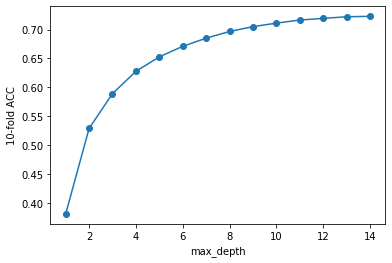

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# grid search
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Entrenamos nuestro modelo con el parametro libre optimo obtenido en el paso anterior

In [66]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=8,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Score Train: ",bagModel.score(X_train,y_train))
print("Score Test: ",bagModel.score(X_test,y_test))

Score Train:  0.7432614339205508
Score Test:  0.6847716637615916


**Analizamos ahora las caracteristicas mas relevantes para nuestro modelo**

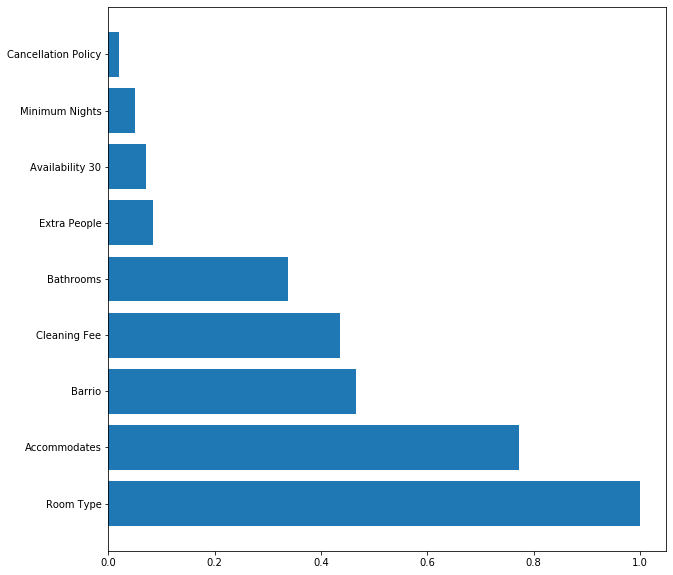

In [67]:
# Tu código aquí
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

feature_names = X_train.columns[0:]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

**Como vemos las caracteristicas mas relevantes siguen practicamente el mismo orden que lo que habiamos obtenido 
mas arriba en las tareas de regularizacion**

Me permito por ultimo copiar esto para tenerlo todo en un unico notebook

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

rf = RandomForestRegressor(oob_score = True)
rf.fit(X_train, y_train)

y_predict = rf.predict(X_test)
rf_testing_set_score = rf.score(X_test, y_test)
rf_median_abs_error = median_absolute_error(y_test, y_predict)
rf_mean_abs_error = mean_absolute_error(y_test, y_predict)
print('R^2 en datos de test: ' + str(round(rf_testing_set_score,3)))
print('Mediana del error en datos de test: ' + str(round(rf_median_abs_error,3)))
print('Media del error en datos de test: ' + str(round(rf_mean_abs_error,3)))

R^2 en datos de test: 0.653
Mediana del error en datos de test: 9.7
Media del error en datos de test: 14.701


In [69]:
tuned_parameters = {
    "n_estimators": [100, 500, 1000, 2000]
}

rf_tuned = GridSearchCV(RandomForestRegressor(), cv = 3, param_grid = tuned_parameters)

preds = rf_tuned.fit(X_train, y_train)
best = rf_tuned.best_estimator_ 
y_predict = rf_tuned.predict(X_test)
rft_testing_set_score = rf_tuned.score(X_test, y_test)
rft_median_abs_error = median_absolute_error(y_test, y_predict)
rf_mean_abs_error = mean_absolute_error(y_test, y_predict)

print('Mejores parámetros:', rf_tuned.best_params_)
print('R^2 en datos de test: ' + str(round(rf_testing_set_score,3)))
print('Mediana del error en datos de test: ' + str(round(rf_median_abs_error,3)))
print('Media del error en datos de test: ' + str(round(rf_mean_abs_error,3)))

Mejores parámetros: {'n_estimators': 1000}
R^2 en datos de test: 0.653
Mediana del error en datos de test: 9.7
Media del error en datos de test: 14.17
